# The HFM library - A fast marching solver with adaptive stencils

## Part : Seismology and crystallography
## Chapter : Metrics defined by a Hooke tensor

In this notebook, we demonstrate anisotropic fast marching with a class of metrics arising in seismic travel time tomography. They characterize the first arrival time of seismic P-waves (compressive waves), in the high frequency asymptotic. The seismic models are implemented in dimension $d \in \{2,3\}$. <!---  (the two dimensional instance being mostly for testing purposes)-->

The eikonal equation arising from the high-frequency asymptotic of seismic waves reads
$$
    \det(m_x(\nabla u) - \rho(x)\mathrm{Id}) = 0,
$$
where for each co-vector $p$ one defines
$$
    m_x(p)_{ij} = \sum_{k,l} c_{ijkl}(x) p_k p_l.
$$
We denoted by $c(x) = (c_{ijkl}(x))$, where $i,j,k,l \in \{1,\cdots,d\}$ the Hooke tensor, which describes the elastic properties of the geological medium. The user must take care to only provide elliptic (or positive) Hooke tensors. This assumption, satisfied in physical contexts, ensures that $m=m_x(p)$ is positive definite as soon as $p\neq 0$. 

The `Seismic.Hooke` class is constructed from the ratio $c/\rho$ of the hooke tensor, given in Voigt notation, divided by the medium density $\rho$.
<!---We use the following conventions, which may be relaxed in the future:---> <!-- This should be in the c++ code --> 
<!---* No normalization of the coefficients by $\sqrt 2$, which is often found in the literature.--->
<!---* The provided tensor should be $c/\rho$, accounting for the density of the medium.---> <!-- The medium density $\rho$ is positive. -->
<!---* The same grid scale is used on each axis.--->

**Accuracy.**
Our implementation of the fast marching method for seismic metrics is designed to achieve high accuracy, up to third order, in smooth test cases. However this capability is not demonstrated in the present notebook, but in [C1 Achieving high accuracy](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/Aa_HighAccuracy.ipynb)

**Work in progress.**
The experiments presented in this notebook are part of the internship of François Desquilbet [link](https://www.see.asso.fr/en/distinction/24512_prix-jeunes-national-andre-blanc-lapierre-2018-trophee-ile-france).
Tutors : J.-M. Mirebeau (CNRS, U. PSud, U. PSaclay), L. Métivier (CNRS, LJK, ISTerre, Univ Grenoble, France) [link](https://www-ljk.imag.fr/membres/Ludovic.Metivier/)

**References** 
The main techniques used are presented in the following publication.

Mirebeau, J.-M. (2014). Efficient fast marching with Finsler metrics. Numerische Mathematik, 126(3), 515–557. [link](https://hal.archives-ouvertes.fr/hal-00736431)

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. A constant medium, with tilted and anelliptic anisotropy](#1.-A-constant-medium,-with-tilted-and-anelliptic-anisotropy)
    * [1.1 Mandel notation](#1.1-Mandel-notation)
  * [2. Varying medium](#2.-Varying-medium)
    * [2.1 Position dependent tilt orientation.](#2.1-Position-dependent-tilt-orientation.)
  * [3. Taking into account the topography](#3.-Taking-into-account-the-topography)
  * [4. Testing reproduction](#4.-Testing-reproduction)
    * [4.1 Case of a constant metric](#4.1-Case-of-a-constant-metric)
    * [4.2 Case with topography](#4.2-Case-with-topography)
  * [5. Three dimensional example](#5.-Three-dimensional-example)
    * [5.1 Case of a constant metric](#5.1-Case-of-a-constant-metric)
    * [5.2 Position dependent metric](#5.2-Position-dependent-metric)
    * [5.3 Topography](#5.3-Topography)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Seismic','FMM'))

In [2]:
from agd import Eikonal
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd.Metrics.Seismic import Hooke
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig, quiver; #savefig.dirName = 'Images/Seismic'
norm_infinity = ad.Optimization.norm_infinity
reduced_models=False

In [3]:
import numpy as np
import scipy.linalg
from copy import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,lp,Hooke,ad
    HFMUtils,lp,Hooke,ad = rreload([HFMUtils,lp,Hooke,ad],rootdir='..')

### 0.1 Additional configuration

**Requires the HFM library**
This notebook is CPU only, requires the HFM library, and in particular it *cannot be run on Google Colab*. Indeed, the generalized fast marching method based on a Hooke tensor is not implemented on the GPU. See this [closely related notebook](TTI.ipynb) for GPU compatible experiments, involving the simpler *Tilted Transversally Isotropic* (TTI) models.

<!---
Uncomment the following line to use the TTI models rather than the full seismic models defined by a Hooke tensor.
**Reduced model.s**
Some simplifications of the above eikonal equations are often considered in the literature, see the `Seismic.Reduced` class.
--->

In [5]:
#raise ad.DeliberateNotebookError("Hooke tensor based eikonal equations not implemented on the CPU")

## 1. A constant medium, with tilted and anelliptic anisotropy

The Hooke tensors and densities of a a small number of geophysical media are provided. 
Here we construct three tensors corresponding to the slice, tilted, of uniform media.

We will use the hooke tensors for the following materials.

In [6]:
mica,stishovite,olivine = Hooke.mica[0],Hooke.olivine[0],Hooke.stishovite[0]

In [7]:
print(mica.extract_xz().hooke) 
print(stishovite.extract_xz().hooke)
print(olivine.extract_xz().hooke)

[[178.   14.5   0. ]
 [ 14.5  54.9   0. ]
 [  0.    0.   12.2]]
[[323.7  71.6   0. ]
 [ 71.6 235.1   0. ]
 [  0.    0.   78.7]]
[[453 203   0]
 [203 776   0]
 [  0   0 252]]


In [8]:
metric_mica = mica.extract_xz().rotate_by(np.pi/6)
metric_stishovite = stishovite.extract_xz().rotate_by(-np.pi/8)
metric_olivine = olivine.extract_xz().rotate_by(np.pi/12)

In [9]:
hfmIn_Constant = Eikonal.dictIn({
    'model': 'Seismic2',
    'exportValues':1,
    'seed':[0.,0.],
    'metric':metric_mica,
    'stencilGeometry':'Square', # Non-adaptive 8-point square stencil
    'exportGeodesicFlow':1,
})
hfmIn_Constant.SetRect(sides=[[-1,1],[-1,1]],dimx=201) # Define the domain
X = hfmIn_Constant.Grid() # Horizontal and vertical axis
hfmIn_Constant.SetUniformTips((6,6))

In [10]:
hfmOut = hfmIn_Constant.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.143545 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [11]:
hfmOut['FMCPUTime'], hfmOut['StencilCPUTime']

(0.143545, 0.000165)

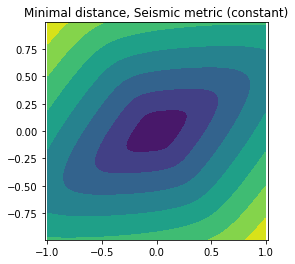

In [12]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal distance, Seismic metric (constant)'); plt.axis('equal')
plt.contourf(*X,hfmOut['values']);

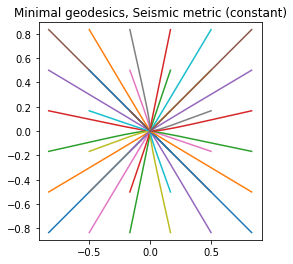

In [13]:
# The geodesics are straight lines, since the metric is constant
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Seismic metric (constant)'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 

The geodesic flow is normalized w.r.t the metric.

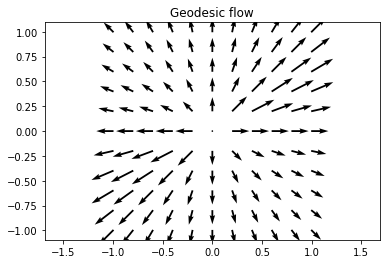

In [14]:
plt.title("Geodesic flow"); plt.axis('equal')
quiver(*X,*hfmOut['flow'],subsampling=(20,20));

In [15]:
flowNorms = hfmIn_Constant['metric'].norm(hfmOut['flow'])
print(f"flow at the seed point : {hfmOut['flow'][:,100,100]}.")
assert (np.abs(flowNorms - 1.)>1e-12).sum() == 1

flow at the seed point : [0. 0.].


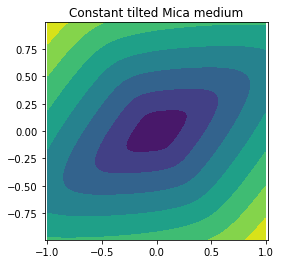

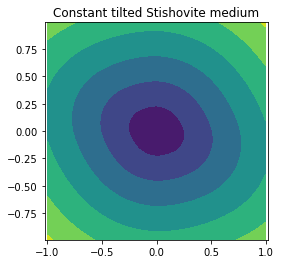

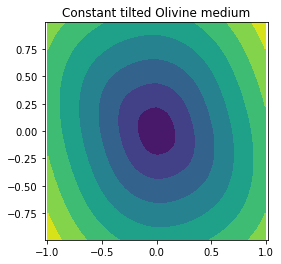

In [16]:
hfmIn_Constant['verbosity']=0
hfmIn_Constant.pop('exportGeodesicFlow',None)
for name,metric in zip(['Mica','Stishovite','Olivine'],[metric_mica,metric_stishovite,metric_olivine]):
    hfmIn_Constant['metric'] = metric
    hfmOut = hfmIn_Constant.Run()
    
    fig = plt.figure(figsize=[4,4]); plt.title("Constant tilted " + name + " medium"); plt.axis('equal')
    plt.contourf(*X,hfmOut['values']);
    
    savefig(fig,"Distance_Constant"+name+".png")

### 1.1 Mandel notation

Mandel notation is a variant of the Voigt notation, introducing normalizing factors of magnitude $\sqrt 2$ and $2$.

In [17]:
metric_mica._Mandel_factors(2) # In dimension two

array([[1.        , 1.        , 1.41421356],
       [1.        , 1.        , 1.41421356],
       [1.41421356, 1.41421356, 2.        ]])

In [18]:
metric_mica._Mandel_factors(3) # In dimension three

array([[1.        , 1.        , 1.        , 1.41421356, 1.41421356,
        1.41421356],
       [1.        , 1.        , 1.        , 1.41421356, 1.41421356,
        1.41421356],
       [1.        , 1.        , 1.        , 1.41421356, 1.41421356,
        1.41421356],
       [1.41421356, 1.41421356, 1.41421356, 2.        , 2.        ,
        2.        ],
       [1.41421356, 1.41421356, 1.41421356, 2.        , 2.        ,
        2.        ],
       [1.41421356, 1.41421356, 1.41421356, 2.        , 2.        ,
        2.        ]])

The eigenvalues of the hooke tensor given in Mandel notation make physical sense, and are invariant upon rotations.

In [19]:
metric = metric_mica.rotate_by(0.5)
eigvals0 = np.linalg.eigvals(metric.to_Mandel())
eigvals1 = np.linalg.eigvals(metric_mica.to_Mandel())
assert norm_infinity(np.sort(eigvals0) - np.sort(eigvals1)) < 1e-12

Define a hooke tensor can be defined from the Mandel notation.

In [20]:
metric2 = Hooke.from_Mandel(metric.to_Mandel())
assert norm_infinity(metric2.hooke - metric.hooke) < 1e-14

## 2. Varying medium

### 2.1 Position dependent tilt orientation.

In [21]:
hfmIn_Varying = Eikonal.dictIn({
    'model':'Seismic2',
    'exportValues':1,
    'seed':[0.,0.],
})

# Define the domain, get the coordinate grid
hfmIn_Varying.SetRect(sides=[[-2,2],[-1,1]],dimx=201)
hfmIn_Varying.SetUniformTips((6,6))
X = hfmIn_Varying.Grid()

In [22]:
# Make small oscillations in the tilting angle
tiltAngle = (np.pi/6.)*np.sin(np.pi*X[0]+1)
metric_var = mica.extract_xz().rotate_by(tiltAngle)

In [23]:
#fig = plt.figure(figsize=[6,3]); plt.title("Varying medium orientation"); plt.axis('equal')
#plt.streamplot(*X,np.cos(tiltAngle),np.sin(tiltAngle))
#savefig(fig,"Medium_MicaVaryingTilt.png")

In [24]:
hfmIn_Varying['metric']=metric_var

In [25]:
hfmOut = hfmIn_Varying.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.103001 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


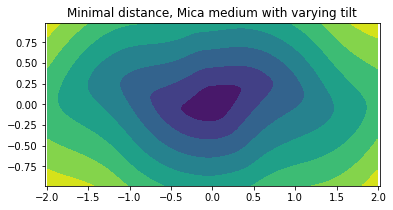

In [26]:
fig = plt.figure(figsize=[6,3]); plt.title('Minimal distance, Mica medium with varying tilt'); plt.axis('equal')
plt.contourf(*X,hfmOut['values']);
savefig(fig,"Distance_MicaVaryingTilt.png")

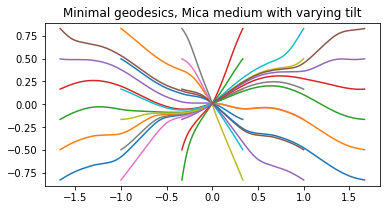

In [27]:
fig = plt.figure(figsize=[6,3]); plt.title('Minimal geodesics, Mica medium with varying tilt'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 

TODO : a piecewise constant medium.

<!---
### 2.2 Piecewise constant medium

#hookeVar2 = np.broadcast_to(hooke1.reshape((3,3,1,1)),hookeVar1.shape).copy()
#hookeVar2[:,:,X>(Z+0.3)] =hooke2 
--->

## 3. Taking into account the topography

The arrival time of seismic waves is, usually, measured at ground level. In order to compute this quantity accurately, a good discretization of the surface topography may be required. 

However, the HFM software can only use rectangular domains (possibly with periodic boundary conditions). A change of variables toward the actual domain is this required, which jacobian matrix locally distorts the metric. Note that Hooke tensors do not define an class of metrics invariant under linear tranformations, as opposed to e.g. Riemannian, Rander, or asymmetric quadratic metrics, hence the jacobian matrix must be specified separately.

<!---
We limit our attention to changes of variables referred to as *topographic transformations*, taking the form
$$
    (x,z) \mapsto (x,z+h(x,z))
$$
and whose jacobian matrix is therefore
$$
    \begin{pmatrix}
        1 & 0 \\
        \partial_x h & 1+ \partial_z h
%        \frac{\partial h(x,y)}{\partial x} & 1+ \frac{\partial h(x,y)}{\partial y}
    \end{pmatrix}
$$
--->

Chosen physical domain is the image of the rectangle $[-1,1]\times [0,1]$ by the smooth mapping $(x,z) \mapsto h(x,z)$ defined below.

In [28]:
def h(x,z,alpha=0.5): return ad.array([x, z + alpha*z*np.sin(np.pi*x)])

We take into account the surface topography, while leaving invariant the other axes.

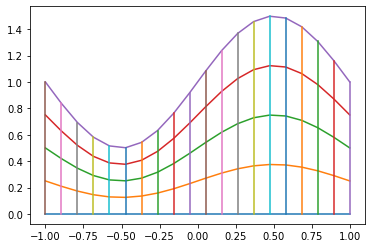

In [29]:
X = np.linspace(-1,1,20)
Z = np.linspace(0,1,5)
for z in Z: plt.plot(*h(X,z)) 
for x in X: plt.plot(*h(x+0.*Z,Z))

In [30]:
hfmIn_Topo = Eikonal.dictIn({
    'model':'SeismicTopographic2',
    'exportValues':1,
    'seed':[0.,0.5],
})

# Define the domain
hfmIn_Topo.SetRect(sides=[[-1,1],[0,1]],dimx=101)
hfmIn_Topo.SetUniformTips((6,6))

X0 = hfmIn_Topo.Grid() # Grid coordinates (horizontal and vertical)
X = h(*X0) # Physical coordinates

We use automatic differentiation to compute the jacobian matrix of the change of variables.

In [31]:
X0_ad = ad.Dense.identity(constant=X0,shape_free=(2,))
Jac = np.moveaxis(h(*X0_ad).gradient(),0,1)

In [32]:
metric_topo = mica.extract_xz().rotate_by(-np.pi/6)
metric_topo = metric_topo.inv_transform(Jac) 

Rotations are handled by modifying the hooke tensor, but general linear transformations are stored separately.

In [33]:
print(f"Required model : {metric_topo.model_HFM()}.",
      f"Stored Jacobian shape : {metric_topo.inverse_transformation.shape}.")

Required model : SeismicTopographic2. Stored Jacobian shape : (2, 2, 101, 50).


In [34]:
hfmIn_Topo['metric'] = metric_topo #.to_HFM() #HookeTopo_to_HFM(hooke,h_grad(X0,Z0))

In [35]:
hfmOut = hfmIn_Topo.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.02486 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


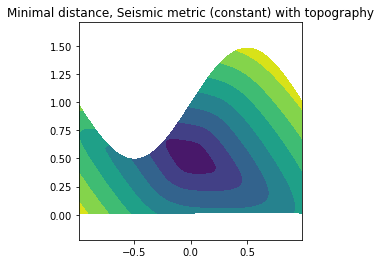

In [36]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal distance, Seismic metric (constant) with topography'); plt.axis('equal')
plt.contourf(*X,hfmOut['values']);

The geodesics are straight lines, except for those which would cross the surface.

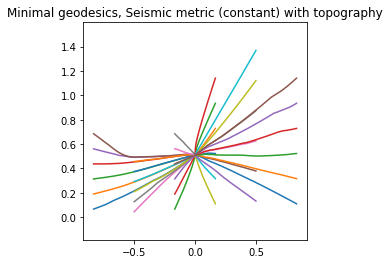

In [37]:
fig = plt.figure(figsize=[4,4]);  plt.axis('equal'); 
plt.title('Minimal geodesics, Seismic metric (constant) with topography');
for geo in hfmOut['geodesics']:  
    plt.plot(*h(*geo)) 

Note that the computation involved a distorted metric, on a distorted domain.

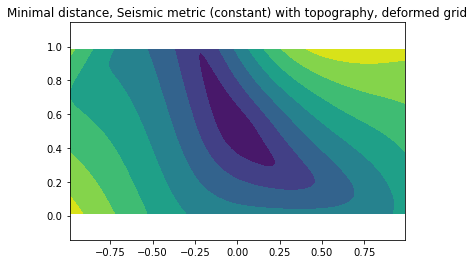

In [38]:
plt.title('Minimal distance, Seismic metric (constant) with topography, deformed grid'); plt.axis('equal')
plt.contourf(*X0,hfmOut['values']);

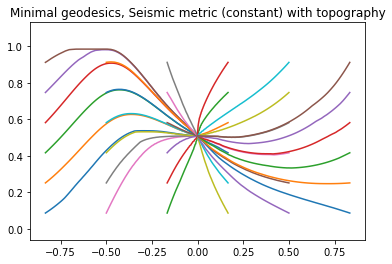

In [39]:
plt.title('Minimal geodesics, Seismic metric (constant) with topography'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 

## 4. Testing reproduction

In this section, we check the soundness of the proposed discretization by comparing the numerical solution with the exact solution, when it is known.

### 4.1 Case of a constant metric

If the metric is constant and if source factorization is used over all the domain, then the exact solution is recovered, up to floating point accuracy.

In [40]:
n=101
hfmIn_Constant.SetRect(sides=[[-1,1],[-1,1]],dimx=n)
hfmIn_Constant.update({
    'factoringRadius':-1, # factorization is used over all the domain 
    'verbosity':1,
})
X = hfmIn_Constant.Grid()

In [41]:
exactSolution = hfmIn_Constant['metric'].norm(X)

In [42]:
hfmOut = hfmIn_Constant.Run()

Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.038104 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


Exact and numerical solution match up to machine arithmetic precision.

In [43]:
assert np.allclose(exactSolution,hfmOut['values'])

The fast marching algorithm, used under the hood, requires the numerical scheme to be causal, and therefore the stencils to be sufficiently refined. If this condition is not met, then a systematic error will occur.
For that purpose, the field *stencilGeometry* should be set to:
* 'None' (default), to produce adaptive stencils automatically obeying the causality property. (With some computational overhead.)
* 'Square', or 'SpikySquare', which are fine enough for the anisotropies encountered in seismology.

In the following example, we purposedly use an under-refined stencil, to illustrate inconsistencies in the lack of causality.

In [44]:
hfmIn_Constant['stencilGeometry']='Diamond' # This stencil is causal only for isotropic metrics

In [45]:
hfmOut = hfmIn_Constant.Run()

Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.016925 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


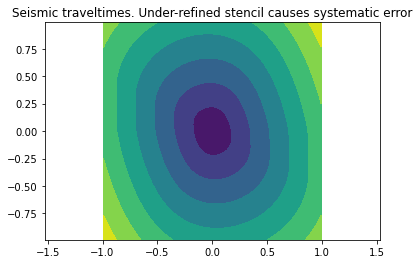

In [46]:
plt.title("Seismic traveltimes. Under-refined stencil causes systematic error"); plt.axis('equal')
plt.contourf(*X,hfmOut['values']);

In [47]:
np.max(np.abs(exactSolution-hfmOut['values']))

0.0009596592201516277

In [48]:
hfmIn_Constant['stencilGeometry']='None' # Use automatically generated adaptive stencils (default)

### 4.2 Case with topography

In the instance involving ground topography, the discretization grid is distorted. Therefore the numerical metric is non-constant, and we cannot expect the numerical method to exactly reproduce the arrival times. 
We compute the exact arrival times as above, by requiring the factor used in the constant case.

In [49]:
X0 = hfmIn_Topo.Grid() # Rectangular coordinates
X = h(*X0) # Physical coordinates
hooke = Hooke(hfmIn_Topo['metric'].hooke[:,:,0,0]) # Hooke tensor only, omits the change of vars
seed = hfmIn_Topo['seed']
exact = hooke.norm(X - fd.as_field(seed,X.shape[1:]))

We introduce source factorization so as to reduce the numerical error of the numerical method. 

In [50]:
hfmIn_Topo['factoringRadius']=-1 # factorization is used over all the domain 

In [51]:
hfmOut = hfmIn_Topo.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.024499 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [52]:
error = exact-hfmOut['values']

Actually, our 'exact' solution is only exact outside the shadow zone, in the upper left part of the domain, which is not connected to the seed by a straight line in the domain.

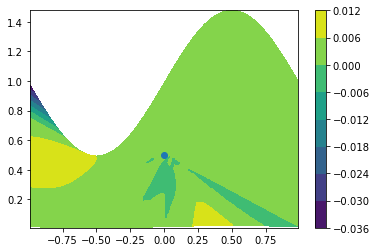

In [53]:
plt.contourf(*X,error)
plt.colorbar()
plt.scatter(*hfmIn_Topo['seed']);

In [54]:
shadowRegion = np.logical_and(X[0]<=-0.4, X[1]>=0.4)
print("Numerical error outside shadow region : ", np.max(np.abs(error * (1-shadowRegion))))
print("Time difference inside shadow region : ", np.max(np.abs(error*shadowRegion)))

Numerical error outside shadow region :  0.010099956307889069
Time difference inside shadow region :  0.0345126586420587


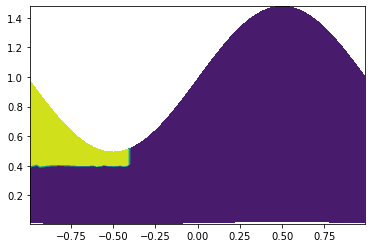

In [55]:
plt.contourf(*X,shadowRegion);

## 5. Three dimensional example

We illustrate the computation of three dimensional seismic wave traveltimes.

### 5.1 Case of a constant metric

The geological medium is defined as tilted mica.

In [56]:
# Define a rotation matrix by its angle and axis
rotation_params = np.pi/3.,(2.,1.,3.)
hooke3D_1 = mica.rotate_by(*rotation_params)
hooke3D_2 = olivine.rotate_by(*rotation_params)

In [57]:
hfmIn3D_Constant = Eikonal.dictIn({
    'model':'Seismic3',    
    'metric':hooke3D_1,
    'seeds':[[0.,0.,0.]],
    'factoringRadius':8,

    'exportValues':1,
    'exportGeodesicFlow':1
})

# Define the domain
n=21; nHalf = n//2
hfmIn3D_Constant.SetRect(sides=[[-1,1],[-1,1],[-1,1]],dimx=n)
X,Y,Z = hfmIn3D_Constant.Grid()

At the time of writing, the *Seismic3* model does not support an adaptive stencil construction, automatically enforcing the causality property. The *stencil geometry* must therefore be explicitly defined, chosen among the following possibilities:
* **CutCube** uses $18$ neighbors. Causal for moderately anisotropic models, such as olivine or stishovite.
* **Cube** uses $26$ neighbors. Intermediate refinement.
* **SpikyCube** uses $50$ neighbors. Causal for the mica medium, which is one of the most strongly anisotropic encountered in seismology.

The numerical cost of the fast marching method is directly impacted by the numeber of neighbors used.

In [58]:
hfmIn3D_Constant['stencilGeometry']='SpikyCube' # Largest stencil, suitable for mica (strong anisotropy)

In [59]:
hfmOut = hfmIn3D_Constant.Run()

Field verbosity defaults to 1
Field checkAcuteness defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 1.16309 s.


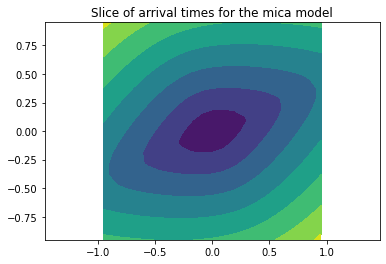

In [60]:
plt.axis('equal'); plt.title('Slice of arrival times for the mica model')
plt.contourf(Y[nHalf],Z[nHalf],hfmOut['values'][nHalf]);

In [61]:
sx,sy,sz = hfmIn3D_Constant['seed']
exact = hfmIn3D_Constant['metric'].norm((X-sx,Y-sy,Z-sz))

In [62]:
error = hfmOut['values']-exact
factoringRegion = np.sqrt(X**2+Y**2+Z**2) < hfmIn3D_Constant['factoringRadius']*hfmIn3D_Constant['gridScale']

Because the metric is constant, the arrival times are exact in the factoring region.

In [63]:
assert norm_infinity(error * factoringRegion) < 1e-16

A small error is omitted elsewhere, which may be improved using a higher order scheme.

In [64]:
print("Global error : ", norm_infinity(error))

Global error :  0.0013982669216928284


Again the geodesic flow is normalized w.r.t. the metric, except at the center point and its immediate neighbors, which are used as seed points.

In [65]:
flowNorms = hfmIn3D_Constant['metric'].norm(hfmOut['flow'])
print(f"Flow norm at a seed point : {flowNorms[nHalf,nHalf,nHalf]}")
assert np.sum(np.abs(flowNorms-1.)>1e-8) <= 3**3

Flow norm at a seed point : 0.0


In [66]:
assert (np.abs(flowNorms-1.)>=1e-12 ).sum() <= 27 

The less anisotropic olivine model can accomodate less refined stencils, and enjoy faster computation times.

In [67]:
hfmIn3D_Constant.update({
    'metric':hooke3D_2,
    'stencilGeometry':'CutCube',
})

In [68]:
hfmOut = hfmIn3D_Constant.Run()

Field verbosity defaults to 1
Field checkAcuteness defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.45489 s.


In [69]:
print(hfmOut['FMCPUTime'])

0.45489


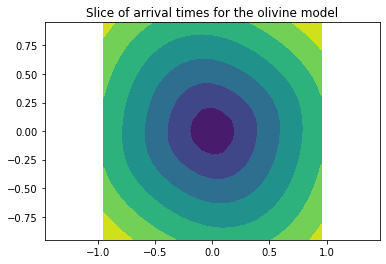

In [70]:
plt.axis('equal'); plt.title('Slice of arrival times for the olivine model')
plt.contourf(Y[nHalf,:,:],Z[nHalf,:,:],hfmOut['values'][nHalf,:,:]);

In [71]:
exact = hfmIn3D_Constant['metric'].norm((X-sx,Y-sy,Z-sz))
error = hfmOut['values']-exact

assert norm_infinity(error * factoringRegion) < 1e-14
print("Global error : ", norm_infinity(error))

Global error :  0.00044082555156935155


Similarly to the two dimensional case, using insufficiently refined stencils breaks the numerical method consistency, and yields inconsistent results.

In [72]:
hfmIn3D_Constant.update({
    'metric':hooke3D_1,
    'stencilGeometry':'CutCube', # Also fails with 'Cube'
})

In [73]:
hfmOut = hfmIn3D_Constant.Run()

Field verbosity defaults to 1
Field checkAcuteness defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.469614 s.


In [74]:
exact = hfmIn3D_Constant['metric'].norm((X-sx,Y-sy,Z-sz))
error = hfmOut['values']-exact
print("Error in factoring region (non-zero due to insufficient refinement): ",norm_infinity(error * factoringRegion))
print("Global error : ", norm_infinity(error))

Error in factoring region (non-zero due to insufficient refinement):  0.0005878288075511218
Global error :  0.0033546075602274017


### 5.2 Position dependent metric

In [75]:
hfmIn3D_Varying = Eikonal.dictIn({
    'model':'Seismic3', 
    'exportValues':1,
    'seed':[0.,0.,0.5],
    'factoringRadius':7,
    'stencilGeometry':'SpikyCube',
    'order':2
})

# Define the domain
n=30; 
hfmIn3D_Varying.SetRect(sides=[[-1,1],[-1,1],[0,1]],dimx=n)

In [76]:
X,Y,Z = hfmIn3D_Varying.Grid()

In [77]:
rotation1 = lp.rotation( (np.pi/6)*np.sin(2*np.pi*(X+0.4)), (1,0,0))
rotation2 = lp.rotation( (np.pi/6)*np.sin(2*np.pi*(Y-0.7)), (0,1,0))
rotation = lp.dot_AA(rotation1,rotation2)

In [78]:
hooke3D_3 = mica.rotate(rotation)

In [79]:
hfmIn3D_Varying['metric'] = hooke3D_3

In [80]:
hfmOut = hfmIn3D_Varying.Run()

Field verbosity defaults to 1
Field checkAcuteness defaults to 0
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 1.72443 s.


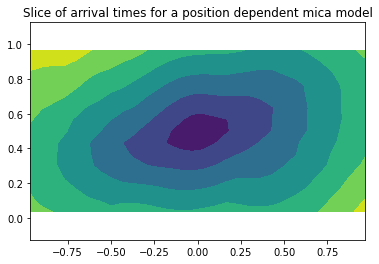

In [81]:
nHalf=n//2
plt.axis('equal'); plt.title('Slice of arrival times for a position dependent mica model')
plt.contourf(Y[nHalf,:,:],Z[nHalf,:,:],hfmOut['values'][nHalf,:,:]);

### 5.3 Topography

$$
    (x,y,z) \mapsto (x,y,z+h(x,y,z))
$$

In [82]:
def h(x,y,z,alpha=0.3):
    return ad.array([x,y,z + alpha*z*np.sin(np.pi*x)*np.cos(np.pi*y)])

In [83]:
hfmIn3D_Topo = Eikonal.dictIn({
    'order':2,
    'model':'SeismicTopographic3',
    'exportValues':1,
    'seed':[0.,0.,0.5],
    'stencilGeometry':'Cube'
})

# Define the domain
n=40
hfmIn3D_Topo.SetRect(sides=[[-1,1],[-1,1],[0,1]],dimx=n)

X0,Y0,Z0 = hfmIn3D_Topo.Grid() # Rectangular coordinates
X,Y,Z = h(X0,Y0,Z0) # Physical coordinates

In [84]:
X_ad,Y_ad,Z_ad = ad.Dense.register(inputs=(X,Y,Z), shape_bound=X.shape)
Jac = np.moveaxis(h(X_ad,Y_ad,Z_ad).gradient(),0,1)

In [85]:
metric = stishovite.rotate_by(np.pi/6,(1,2,3))
metric = metric.inv_transform(Jac)
hfmIn3D_Topo['metric'] = metric

In [86]:
metric.hooke.shape

(6, 6, 40, 40, 20)

In [87]:
hfmOut = hfmIn3D_Topo.Run()

Field verbosity defaults to 1
Field checkAcuteness defaults to 0
Field seedRadius defaults to 0
Fast marching solver completed in 2.28116 s.


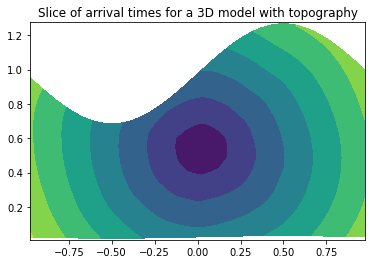

In [88]:
nHalf=n//2
plt.axis('equal'); plt.title('Slice of arrival times for a 3D model with topography')
plt.contourf(X[:,nHalf,:],Z[:,nHalf,:],hfmOut['values'][:,nHalf,:]);